In [1]:
%%capture
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py

In [2]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

# Data

In [3]:
# Tokenizing & applying BPE rules

tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')


# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)  # 1. learn_bpe rules
    bpe[lang] = BPE(open('./bpe_rules.' + lang))  # 2. create instance of BPE class
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')  # 3. apply BPE tokenization to our data        


# Building vocabularies

data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')            

from vocab import Vocab

inp_voc = Vocab.from_lines(train_inp) # creates an instance of Vocab class from input lines (ru (input) vocab here)
out_voc = Vocab.from_lines(train_out) # en (output) vocab

print(f'Length of input (Russian) BPE vocabulary = {len(inp_voc)}')
print(f'Length of output (English) BPE vocabulary = {len(out_voc)}')

100%|██████████| 8000/8000 [00:11<00:00, 697.40it/s]


inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .

Length of input (Russian) BPE vocabulary = 8048
Length of output (English) BPE vocabulary = 7801


# Encoder-decoder models

## Basic model (Single GRU/GRU, no attention or anything)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
from models import BasicModel

model = BasicModel(inp_voc, out_voc).to(device)

# debugging area

dummy_inp_tokens = inp_voc.to_matrix(train_inp[:5]).to(device)
dummy_out_tokens = out_voc.to_matrix(train_out[:5]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

# Loss:

from utils import compute_loss

dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 8.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

# Evaluation: BLEU

from utils import compute_bleu

# BLEU of untrained model
%time print(f"BLEU of untarined model: {compute_bleu(model, dev_inp, dev_out, device=device)}")

Loss: tensor(8.5097, device='cuda:0', grad_fn=<NegBackward0>)
BLEU of untarined model: 0.001766129591574868
CPU times: user 14.1 s, sys: 36.7 ms, total: 14.1 s
Wall time: 14.4 s


In [50]:
from IPython.display import clear_output
from tqdm import tqdm, trange
from utils import save_checkpoint, load_checkpoint

model = BasicModel(inp_voc, out_voc).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 64

### Training

In [12]:
# training

def train_loop(model, optimizer, train_inp, num_epochs=25000, from_checkpoint=False):   

    metrics = {'train_loss': [], 'dev_bleu': [] }

    if from_checkpoint:
        best_checkpoint = torch.load('/content/best_bleu_state.pth')
        model.load_state_dict(best_checkpoint["state_dict"])
        best_bleu = best_checkpoint['bleu']
    else:
        best_bleu = 0

    for epoch in trange(num_epochs):
        batch_ix = np.random.randint(len(train_inp), size=batch_size)
        batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
        batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
        
        optimizer.zero_grad() # set the gradients to zero before backpropagation
        loss_t = compute_loss(model, batch_inp, batch_out)
        loss_t.backward()
        optimizer.step()

        
        metrics['train_loss'].append((epoch+1, loss_t.item()))
        
        if (epoch+1) % 100 == 0:
            bleu = compute_bleu(model, dev_inp, dev_out, device=device)
            metrics['dev_bleu'].append((epoch+1, bleu))
            
            if bleu > best_bleu:
                best_bleu = bleu
                checkpoint = {
                    'state_dict' : deepcopy(model.state_dict()), 
                    'optimizer' : deepcopy(optimizer.state_dict()),
                    'epoch' : epoch+1,
                    'bleu' : bleu,
                }
                save_checkpoint(checkpoint, filename="best_bleu_state.pth")

            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
    
    return metrics

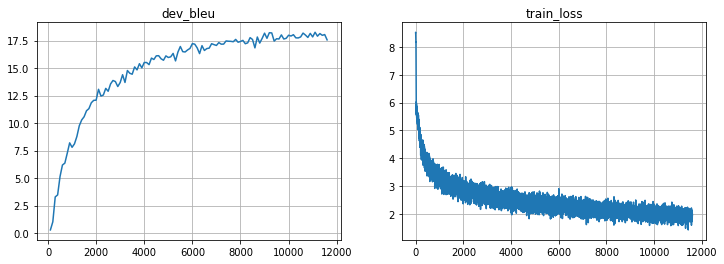

Mean loss=1.944


 58%|█████▊    | 11699/20000 [19:12<13:38, 10.15it/s]


KeyboardInterrupt: ignored

In [51]:
metrics = train_loop(
    model,
    optimizer, 
    train_inp, 
    num_epochs=20000,
    from_checkpoint=False
)

In [53]:
best_checkpoint = torch.load('/content/best_bleu_state.pth')
print('best BLEU = ', best_checkpoint['bleu'])
print('best epoch = ', best_checkpoint['epoch'])

best BLEU =  18.263058961765427
best epoch =  11100


### Beam research

In [54]:
# Return to best checkpoint

print("=> Loading checkpoint")
model.load_state_dict(best_checkpoint["state_dict"])
optimizer.load_state_dict(best_checkpoint["optimizer"])

=> Loading checkpoint


In [16]:
def beam_research(model, inp, out, model_name, beam_min=1, beam_max=10):
    """BLEU scores of a model with different beam_size"""
    
    beam_range = range(beam_min, beam_max + 1)
    blue_scores = []

    for beam_size in beam_range:
        blue = compute_bleu(model, inp, out, beam_size=beam_size, device=device)
        blue_scores.append(blue)

    plt.figure(figsize=(12, 5))
    plt.plot(beam_range, blue_scores)
    plt.title('Beam search results for %s' % model_name)
    plt.xticks(beam_range)
    plt.xlabel('beam size')
    plt.ylabel('BLEU score')
    plt.show()

In [ ]:
%time beam_research(model, dev_inp, dev_out, 'basic model')

### BasicModel translations

In [ ]:
for inp_line, trans_line, out_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], device=device)[0], dev_out[::500]):
    print(f'input line: {inp_line}')
    print(f'translated line: {trans_line}')
    print(f'target line: {out_line}')
    print()

In [ ]:
for inp_line, trans_line, out_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], device=device, beam_size=2)[0], dev_out[::500]):
    print(f'input line: {inp_line}')
    print(f'translated line: {trans_line}')
    print(f'target line: {out_line}')
    print()

## Attentive model (3-layer Bi-LSTM / GRU + Luong attn)

In [25]:
from models import AttentiveModel

# low resource setup (emb_size=64, hid_size=128, num_layers=3, attn_size=128) => low BLEU
model = AttentiveModel(inp_voc, out_voc, num_layers=3, bid=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

### Training

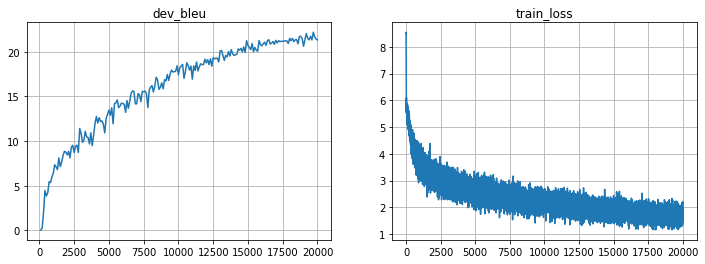

Mean loss=1.641


100%|██████████| 20000/20000 [1:09:10<00:00,  4.82it/s]


In [26]:
metrics = train_loop(
    model,
    optimizer, 
    train_inp, 
    num_epochs=20000,
    from_checkpoint=False
)

In [29]:
best_checkpoint = torch.load('/content/best_bleu_state.pth')
print('best BLEU = ', best_checkpoint['bleu'])
print('best epoch = ', best_checkpoint['epoch'])

print('Mean BLEU on last 10 epoches = ', np.mean(metrics['dev_bleu'][-10:], axis=0)[1]) # Attentive model BLEU

best BLEU =  22.174532910837424
best epoch =  19700
Mean BLEU on last 10 epoches =  21.575823192706565


In [31]:
compute_bleu(model, dev_inp, dev_out, beam_size=1, device=device)

22.174532910837424

### Beam research 

In [30]:
# Return to best checkpoint

print("=> Loading checkpoint")
model.load_state_dict(best_checkpoint["state_dict"])
optimizer.load_state_dict(best_checkpoint["optimizer"])

=> Loading checkpoint


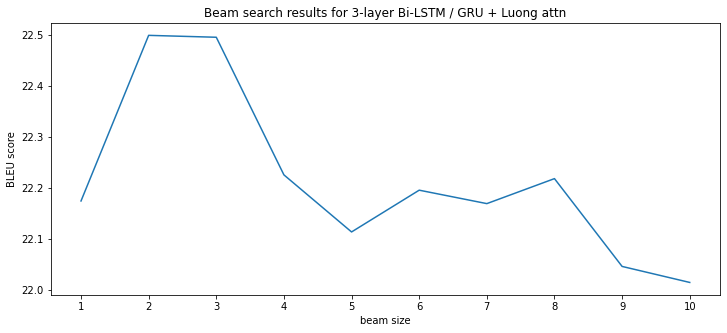

CPU times: user 20min 43s, sys: 9.16 s, total: 20min 52s
Wall time: 21min 16s


In [33]:
%time beam_research(model, dev_inp, dev_out, '3-layer Bi-LSTM / GRU + Luong attn')

In [35]:
compute_bleu(model, dev_inp, dev_out, beam_size=2, device=device)

22.49986121856721

In [36]:
compute_bleu(model, dev_inp, dev_out, beam_size=3, device=device)

22.496119714967975

### Attentive model translations

In [34]:
for inp_line, trans_line, out_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], beam_size=2, device='cuda')[0], dev_out[::500]):
    print(f'input line: {inp_line}')
    print(f'translated line: {trans_line}')
    print(f'target line: {out_line}')
    print()

input line: в распоряжении гостей общая кухня и общая гостиная .
translated line: there is a shared kitchen and a shared kitchen .
target line: a shared equipped kitchen and a common living room are provided to guests .

input line: кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
translated line: it offers car hire , dry cleaning and free parking .
target line: bicycle rental and shuttle services are also available . the property offers free parking .

input line: расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
translated line: the town of is 25 km away .
target line: the unit is 26 km from kissimmee .

input line: апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
translated line: located just a 5 - minute walk from the beach , villa stella features an outdoor pool and a garden , sun terrace and sun terrace .
target li

## Attentive model (same model but larger)

In [40]:
# large-scale setup (emb_size=256, hid_size=256, attn_size=256)
model = AttentiveModel(inp_voc, out_voc, emb_size=256, 
                       hid_size=256, attn_size=256, bid=True).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 64

### Training

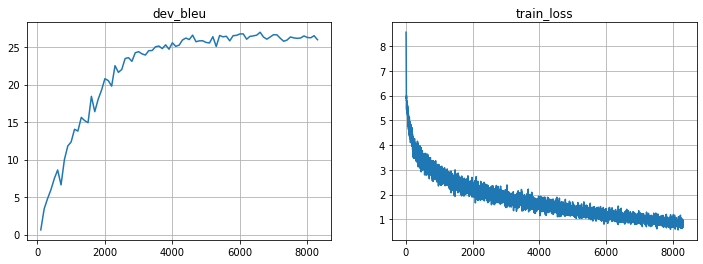

Mean loss=0.847


 83%|████████▎ | 8316/10000 [42:02<08:30,  3.30it/s]


KeyboardInterrupt: ignored

In [41]:
metrics = train_loop(
    model,
    optimizer, 
    train_inp, 
    num_epochs=10000,
    from_checkpoint=False
)

In [44]:
best_checkpoint = torch.load('/content/best_bleu_state.pth')
print('best BLEU = ', best_checkpoint['bleu'])
print('best epoch = ', best_checkpoint['epoch'])

best BLEU =  26.987506373556407
best epoch =  6600


### Beam research

In [45]:
# Return to best checkpoint

print("=> Loading checkpoint")
model.load_state_dict(best_checkpoint["state_dict"])
optimizer.load_state_dict(best_checkpoint["optimizer"])

=> Loading checkpoint


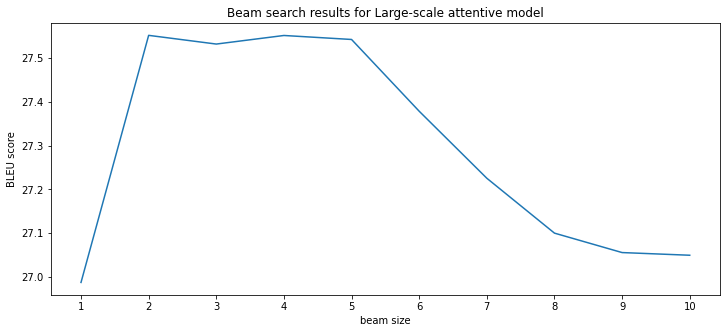

CPU times: user 21min 35s, sys: 13.8 s, total: 21min 48s
Wall time: 21min 49s


In [46]:
%time beam_research(model, dev_inp, dev_out, 'Large-scale attentive model')

### Attentive model translations

In [48]:
compute_bleu(model, dev_inp, dev_out, beam_size=2, device=device)

27.552260950391215

In [49]:
compute_bleu(model, dev_inp, dev_out, beam_size=4, device=device)

27.551974330162672

In [47]:
for inp_line, trans_line, out_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], beam_size=2, device='cuda')[0], dev_out[::500]):
    print(f'input line: {inp_line}')
    print(f'translated line: {trans_line}')
    print(f'target line: {out_line}')
    print()

input line: в распоряжении гостей общая кухня и общая гостиная .
translated line: guests have access to a shared kitchen and a shared lounge .
target line: a shared equipped kitchen and a common living room are provided to guests .

input line: кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
translated line: bicycle , shuttle services and free parking are provided .
target line: bicycle rental and shuttle services are also available . the property offers free parking .

input line: расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
translated line: s@@ io@@ ur is 26 km away .
target line: the unit is 26 km from kissimmee .

input line: апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
translated line: featuring a fully equipped kitchen , a garden and a sun terrace , apartments and large garden is set in lignano sabbiadoro

## Transformer model

In [ ]:
!pip install datasets transformers sacrebleu torch sentencepiece transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 33.5 MB/s 
     |████████████████████████████████| 5.5 MB 52.7 MB/s 
     |████████████████████████████████| 118 kB 35.3 MB/s 
     |████████████████████████████████| 1.3 MB 59.9 MB/s 
     |████████████████████████████████| 212 kB 69.4 MB/s 
     |████████████████████████████████| 115 kB 65.3 MB/s 
     |████████████████████████████████| 182 kB 12.2 MB/s 
     |████████████████████████████████| 127 kB 72.6 MB/s 
     |████████████████████████████████| 7.6 MB 61.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import transformers

from transformers import AutoTokenizer
    
model_checkpoint = "Helsinki-NLP/opus-mt-ru-en"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.7/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


### Data prep

In [ ]:
from datasets import Dataset, DatasetDict
from datasets import load_dataset, load_metric

def parse_ruencorp(train_inp=train_inp, dev_inp=dev_inp, train_out=train_out, dev_out=dev_out, mode='train'):
    if mode == 'train':
        for src_line, dst_line in zip(train_inp, train_out):
            yield {"translation": {"ru": src_line, "en": dst_line}}
    elif mode == 'test':
        for src_line, dst_line in zip(dev_inp, dev_out):
            yield {"translation": {"ru": src_line, "en": dst_line}}

In [ ]:
train_df = pd.DataFrame(parse_ruencorp(mode='train'))
test_df = pd.DataFrame(parse_ruencorp(mode='test'))

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

raw_datasets = DatasetDict({'train': train_dataset, 
                            'test': test_dataset})

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 47001
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
})

In [ ]:
prefix = ""
max_input_length = 128
max_target_length = 128
source_lang = "ru"
target_lang = "en"
def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
preprocess_function(raw_datasets['train'][:2])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3547: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


{'input_ids': [[17, 1851, 151, 60, 3542, 7977, 4165, 7732, 529, 46304, 24542, 300, 21, 3, 0], [3301, 143, 21, 2, 6, 239, 3732, 1004, 6706, 426, 3118, 8069, 10071, 6863, 100, 7, 1654, 2801, 3832, 100, 21, 3, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[1586, 1255, 19425, 34, 815, 25, 4492, 21, 3, 0], [26948, 127, 1052, 634, 30335, 8, 42920, 513, 13, 239, 27, 6179, 6441, 21, 3, 0]]}

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

  0%|          | 0/48 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to("cuda")

Downloading:   0%|          | 0.00/307M [00:00<?, ?B/s]

In [ ]:
batch_size = 64
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True    
)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from datasets import load_metric
metric = load_metric("sacrebleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels
    
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

### Fine-tuning

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation. If translation are not expected by `MarianMTModel.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 47001
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1469
  Number of trainable parameters = 76147712


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,1.428100,1.225223,33.936800,27.064300


Saving model checkpoint to opus-mt-ru-en-finetuned-ru-to-en/checkpoint-500
Configuration saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-500/config.json
Model weights saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-500/pytorch_model.bin
tokenizer config file saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-500/tokenizer_config.json
Special tokens file saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-500/special_tokens_map.json
Saving model checkpoint to opus-mt-ru-en-finetuned-ru-to-en/checkpoint-1000
Configuration saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-1000/config.json
Model weights saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-1000/tokenizer_config.json
Special tokens file saved in opus-mt-ru-en-finetuned-ru-to-en/checkpoint-1000/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `MarianMTModel

TrainOutput(global_step=1469, training_loss=1.5474604638439202, metrics={'train_runtime': 917.9499, 'train_samples_per_second': 51.202, 'train_steps_per_second': 1.6, 'total_flos': 1256455078281216.0, 'train_loss': 1.5474604638439202, 'epoch': 1.0})

### Transformer model translations

In [ ]:
def translate(src_text):
    translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to('cuda'))
    return [tokenizer.decode(t, skip_special_tokens=True) for t in translated]    

In [ ]:
translated_inp = [translate(inp) for inp in dev_inp[::500]]

for inp_line, trans_line, out_line in zip(dev_inp[::500], translated_inp, dev_out[::500]):
    print(f'input line: {inp_line}')
    print(f'translated line: {trans_line}')
    print(f'target line: {out_line}')
    print()